# Visualizing attention-only transformer

This notebook reproduces the results of the blog post [???]. 

In [1]:
import torch as t
from utils import power_unif_law, generate_data
import train
import interp
import matplotlib.pyplot as plt
from models import AoT

## Defining Transformers 

We strat by initializing the Transformer. The proposed Transformer are designed to match the ones from the blog post.\
Then we train the Transformer on an associative memory task: the prior distribution is $\pi(t_1,t_2) = \frac{1}{dict\_ size^2}$ 
while the posterior is $\pi(t_3|t_1, t_2)\in\{0,1\}$.
* T1 and T3 should have 0.99 accuracy, they are able to remember every associations,
* T2 however cannot remember every association since it has only one attention head,

In [2]:
transformer_id = "T1"

# Tunable parmaters
if transformer_id == "T1":
    dict_size = 5
    nb_head = 1
    nb_att_mod = 3
elif transformer_id == "T2":
    dict_size = 3
    nb_head = 1
    nb_att_mod = 1
elif transformer_id == "T3":
    dict_size = 5
    nb_head = 3
    nb_att_mod = 3

# Common parameters
context_window = 3
nb_layers = 1
emb_dim = 3

model = AoT(emb_dim, dict_size, nb_layers, nb_att_mod, nb_head, context_window, pi=[])

In [3]:
t.manual_seed(0)

# Training parameters
batch_size=2**9
num_batch=4000
lr=1e-3

#Distribution parameters 
pi = power_unif_law([1, 1, 1], [dict_size, dict_size, 1], dict_size)
model.pi = pi

#Training set
Data = generate_data(batch_size, num_batch, pi, context_window)

Dict = train.train(model, Data, lr)
print("KL-divergence: ", sum(Dict['Loss'][-101:-1])/100)
print("Accuracy: ", sum(Dict['Acc'][-101:-1])/100)

del Data

100%|██████████| 4000/4000 [00:19<00:00, 209.05it/s]

KL-divergence:  0.0006275319191627204
Accuracy:  1.0


## Visualizing the Transformer on a Torus

There are 5 different classes to be predicted, each one represented by a color.\
Thus, the Transformer can be understood as a map from the torus to the predicted class: $T:\mathbb{S}^1\times\mathbb{S}^1\rightarrow[dict\_ size]$.\
We plot below the probability of the most likely class, the color of that class is the maximum, where intensity encodes probability.

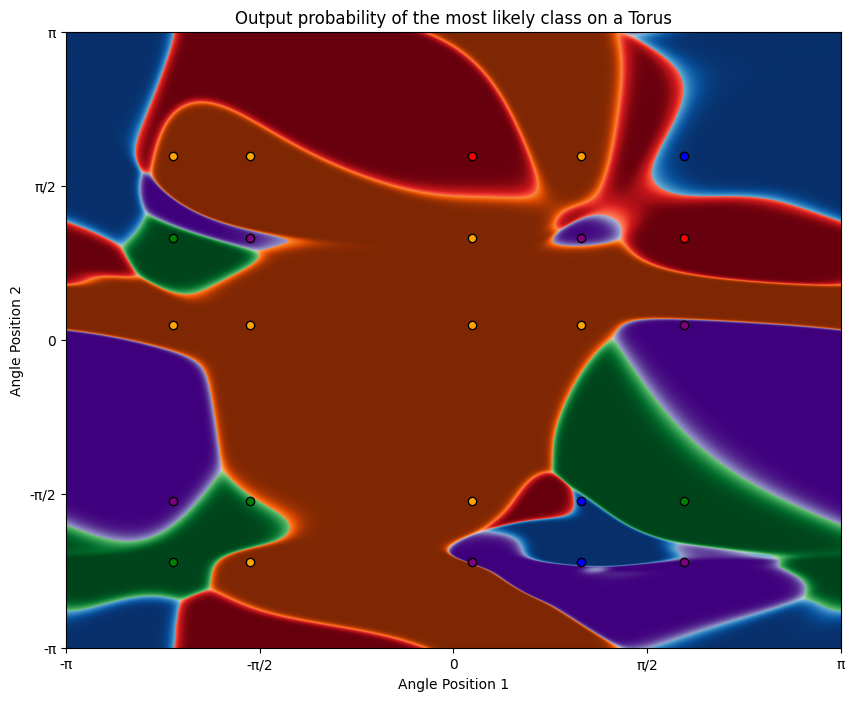

In [4]:
interp.plot_classes_full_torus(model)

## Visualizing the unembedding

Now that we have a trained Transformer, we can start by visualizing the unembedding $W_U$. Since the task is to predict a single class for each input, $W_U$ can be viewed as a clustering of $\mathbb{R}^3$. The clusters corresponds to weigthed Voronoi cells $V_{cells}(c) = \{x: w_U(c)\cdot x \geq w_U(c')\cdot x\}$. Note that the norm of a vector doesn't change its cell, thus we can plot the clustering on the sphere.\
On the graph, we represent each cluster by a color, as well as black dots for the images of token pairs by the Attention layer, and white dots for the normalized columns of $W_U$. 

In [5]:
interp.plot_unemb(model)

## Visualizing an attention head

The attention pattern formula is given by $a(e_1, e_2) = \frac{1}{1+e^{raw(e_1, e_2)}}$ and $raw(e_1, e_2) = (e_2+pos_2)^TW_{QK}(e_2+pos_2 - e_1-pos_1)$. $a$ is the probability of position 2 attending to position 1.

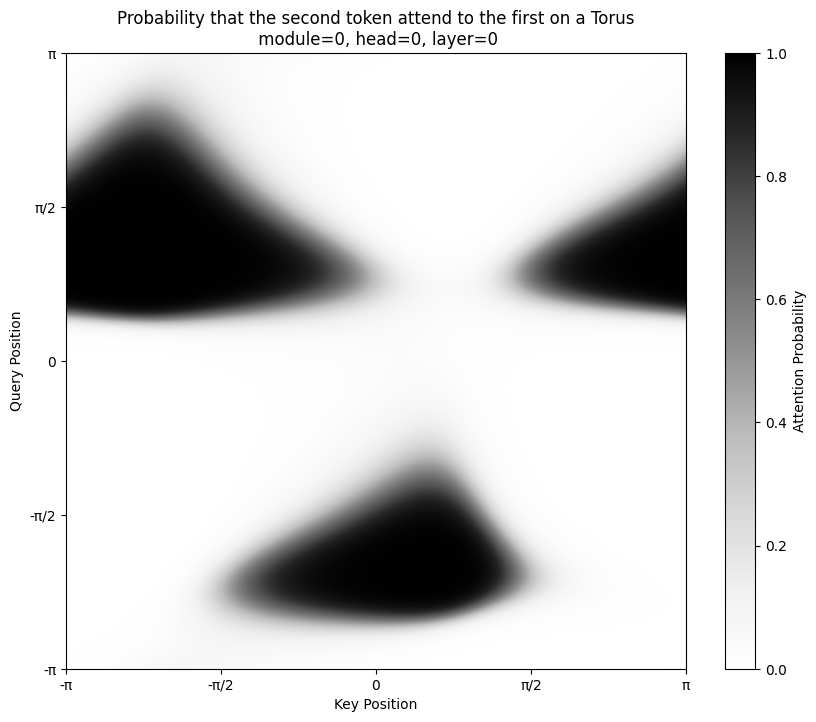

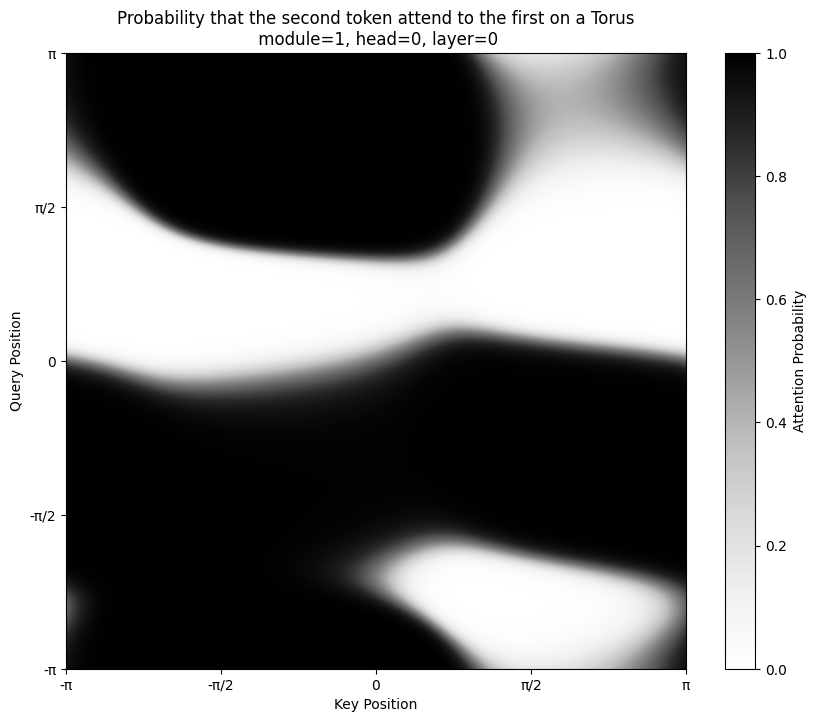

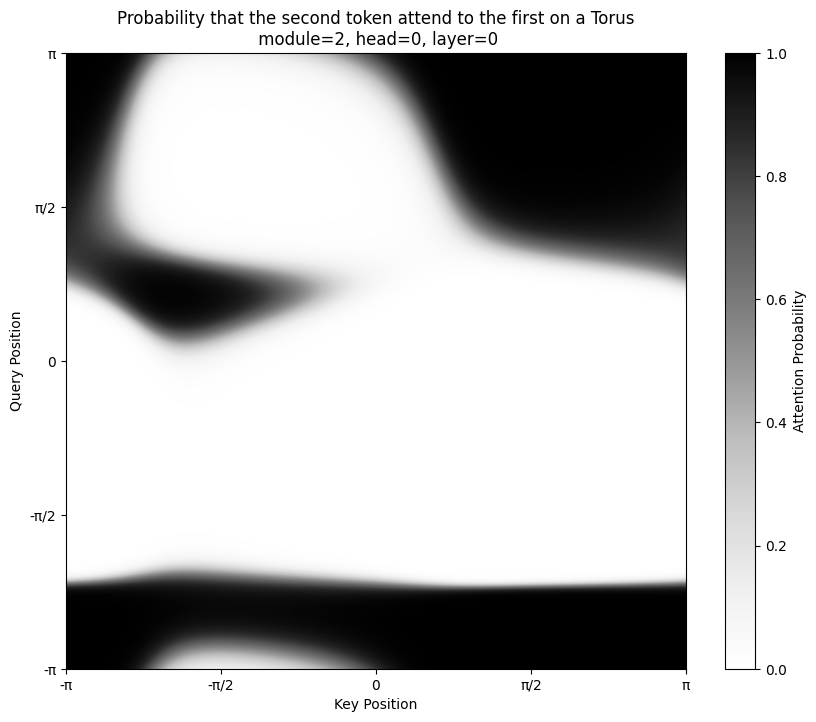

In [6]:
hardmax = False
for module in range(nb_att_mod):
    for head in range(nb_head):
        interp.plot_attention_torus(model, module, head, hardmax=hardmax)

Below is the code to visualize the embedding space outputed by a specific layer & module & head. \
As explained in the blogpost, one can seperate the output between a positional term $a_1(e_1,e_2)*pos_1 + a_2(e_1,e_2)*pos_1$ and a token term $a_1(e_1,e_2)*e_1 + a_2(e_1,e_2)*e_1$.\
The 'mode' parameter controls computation is done. One can also choose to visualize the output embedding space before or after the $W_{OV}$ product.\
\
*About scaling*: to visualize the images in RGB we rescale them to $[0,1]$. Basically, the unscaled RGBs given to the function 'plot_RGB_torus' will be rescaled using the same parameter, making the plots summable. Thus, the image given by the functions 'pos' and 'word' can be added to give exactly th result of 'both'. Note that each dimension has its own rescaling to make the color more vivid.

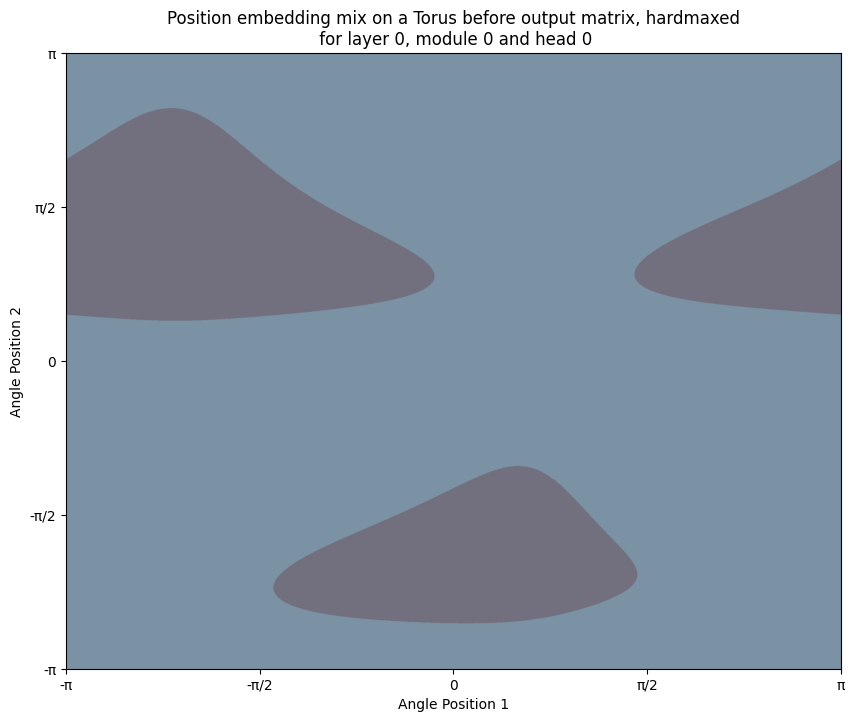

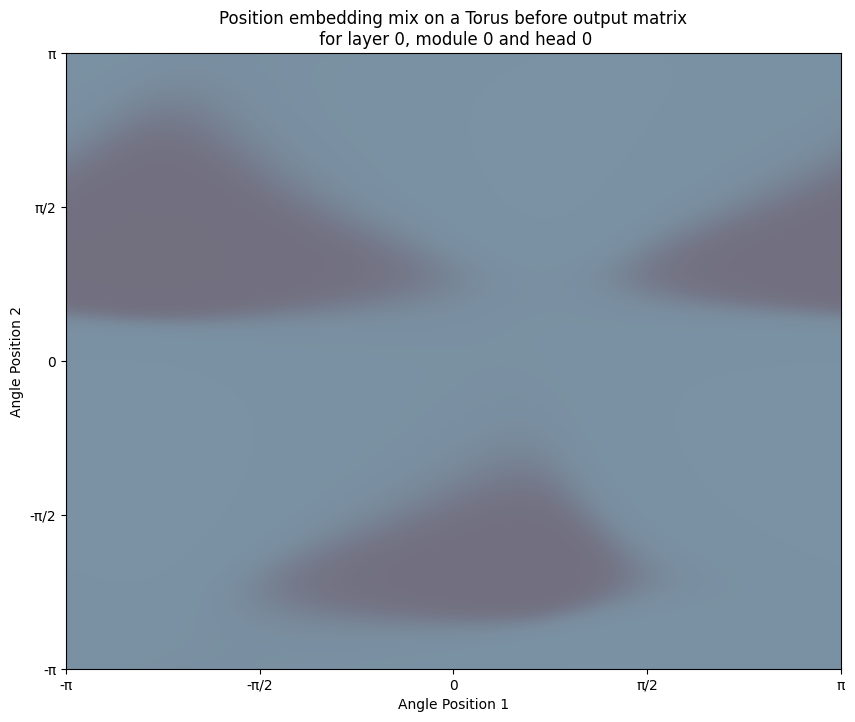

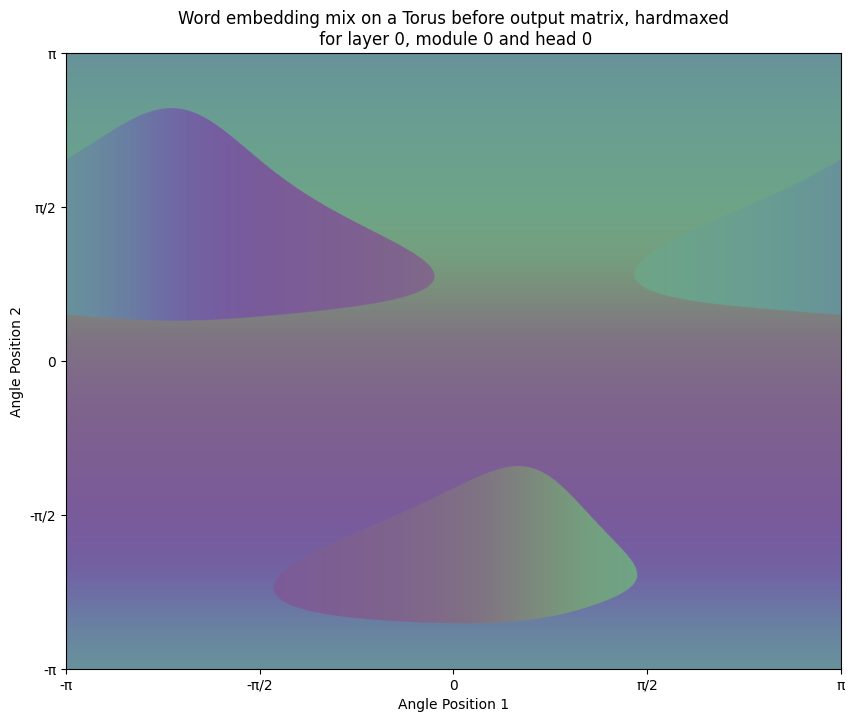

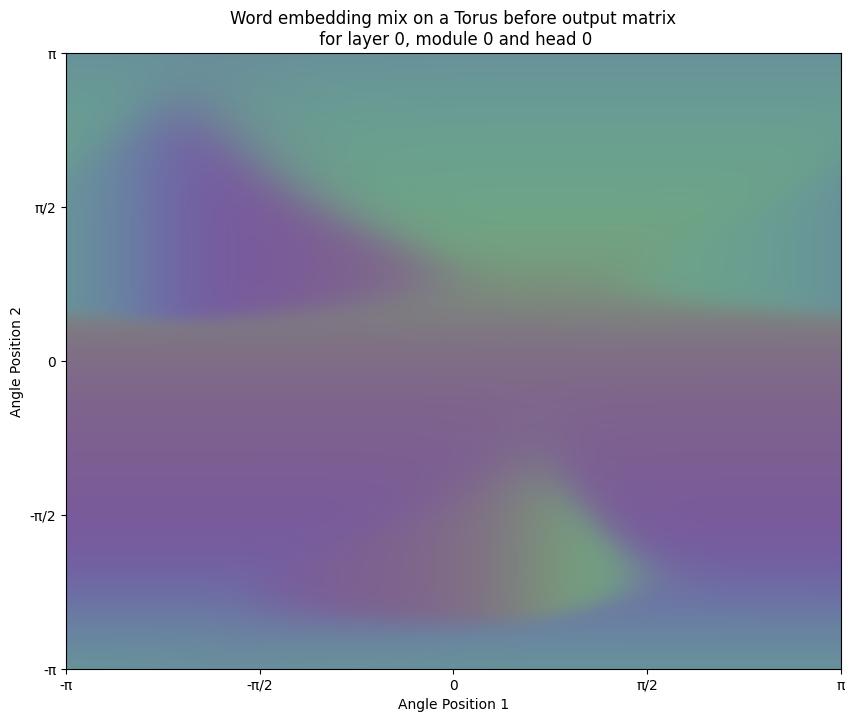

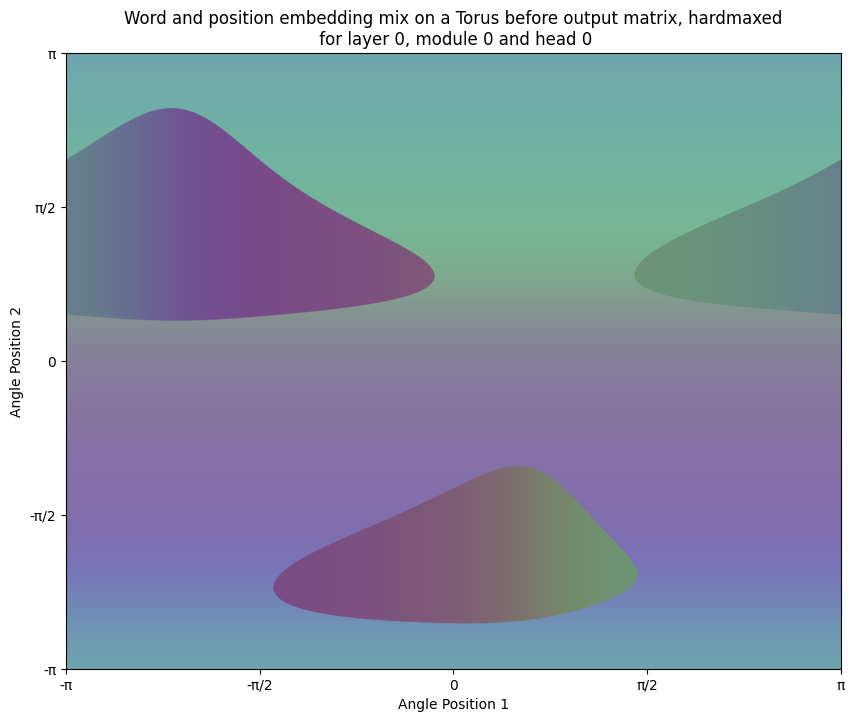

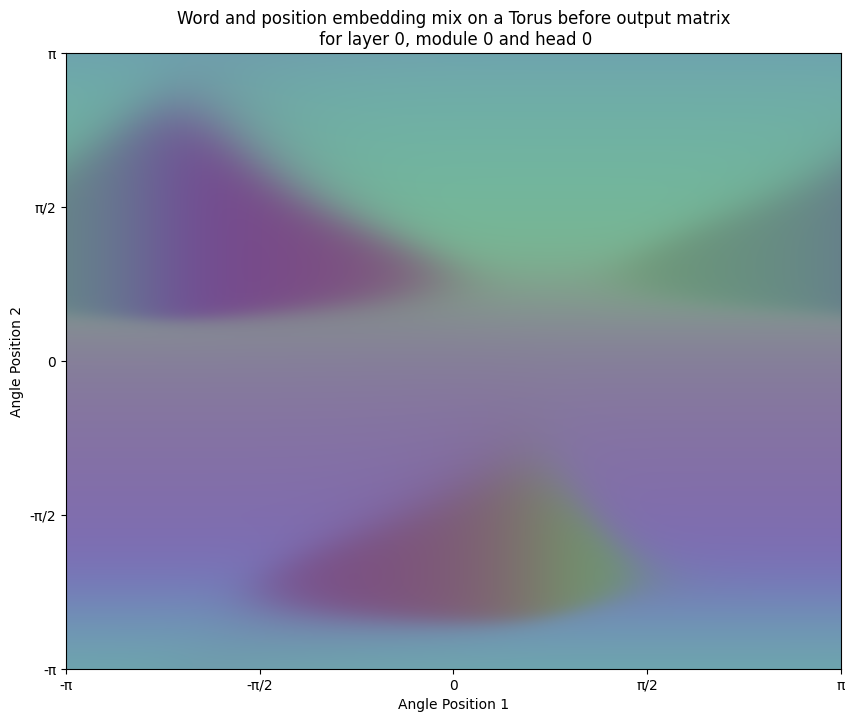

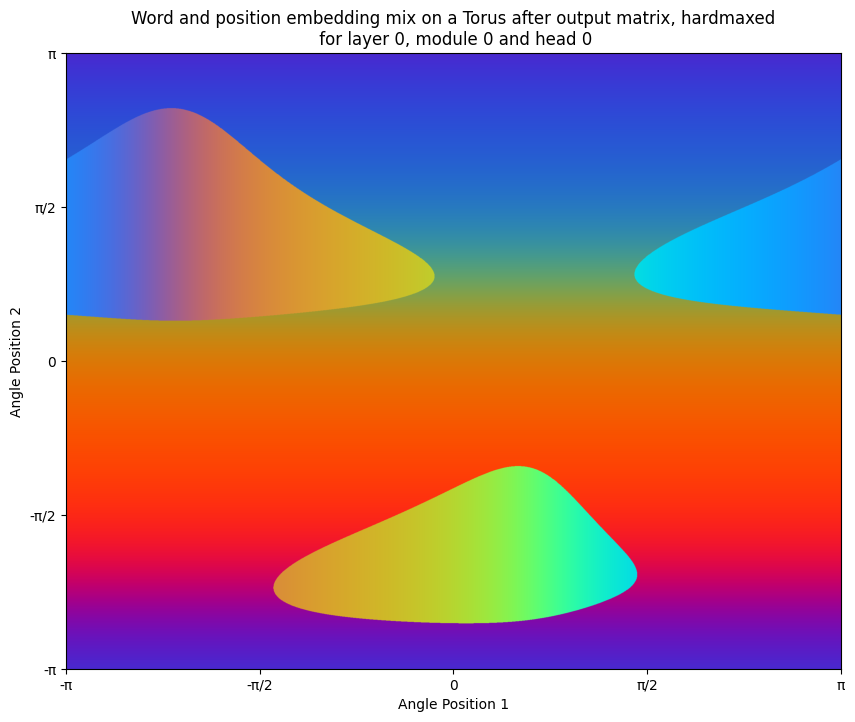

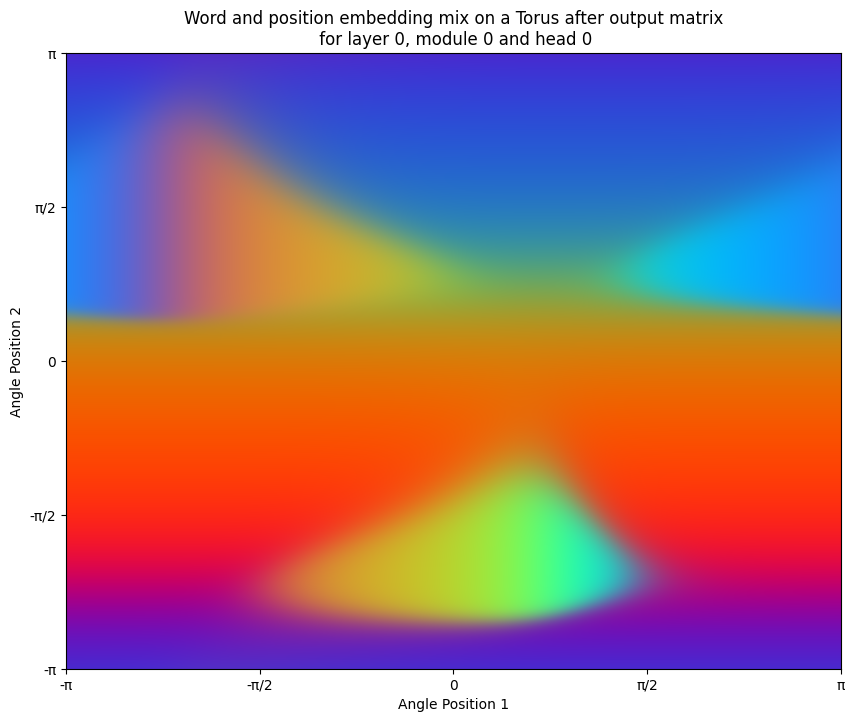

In [7]:
module = 0
head = 0
layer = 0

unscaled_RGBs = []

unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="pos", hardmax=True, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="pos", hardmax=False, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="word", hardmax=True, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="word", hardmax=False, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="both", hardmax=True, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="both", hardmax=False, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="both", hardmax=True, use_OV=True))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="both", hardmax=False, use_OV=True))

# Plot all the graphs stored into data_list
interp.plot_RGB_torus(unscaled_RGBs)

Using the same function, we can also print the output of each head as well as how they combine.\
Thanks to the additivity of the plots, we can see that some properties of the sum of the heads are just properties of the heads.\
Especially, the edges, at which we have a change of colors, are edges of one of the plots, just superposed. \
So the edges of the attention pattern will determine the edges of the final figure.

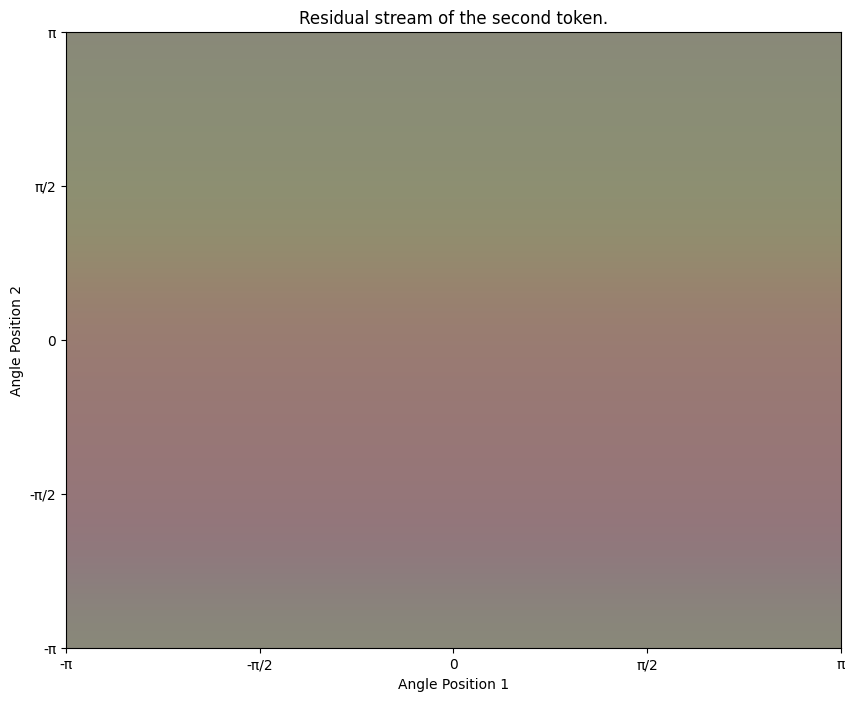

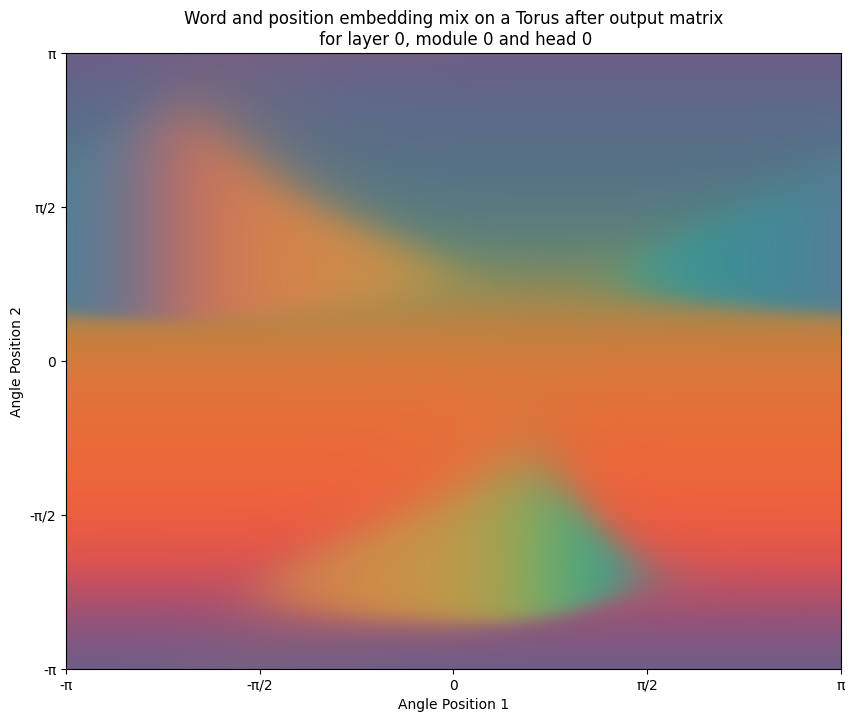

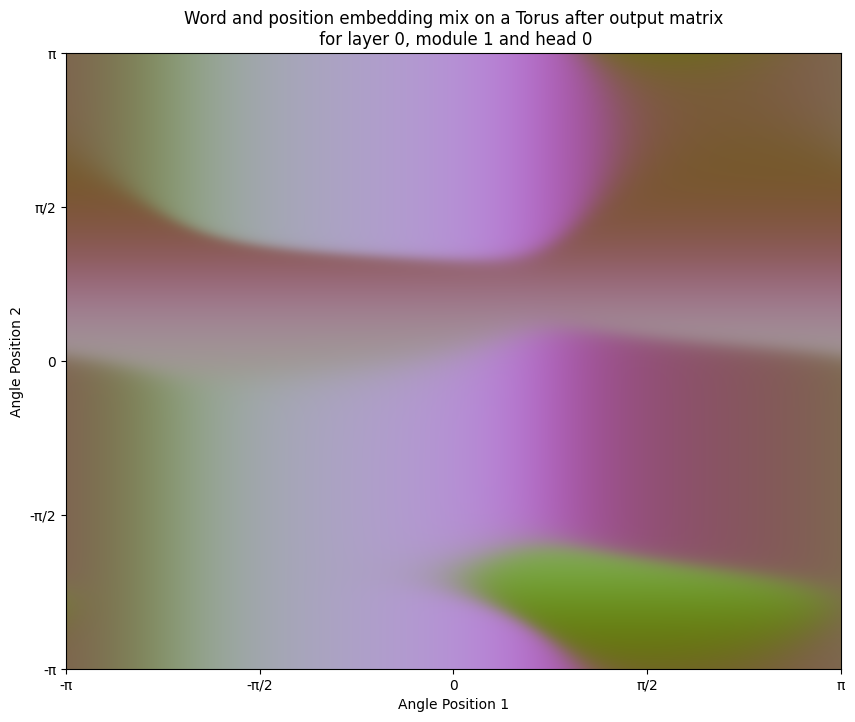

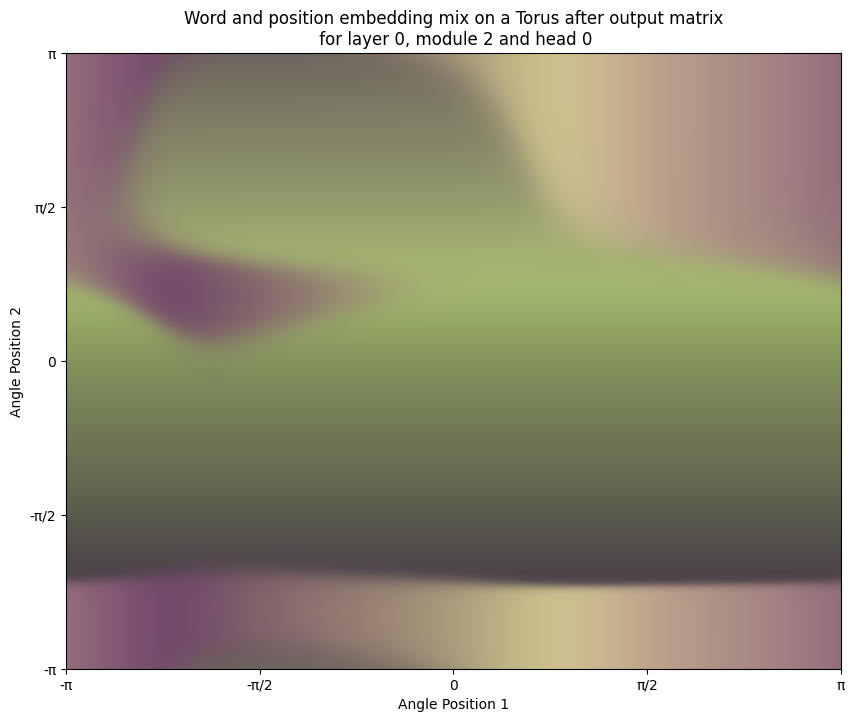

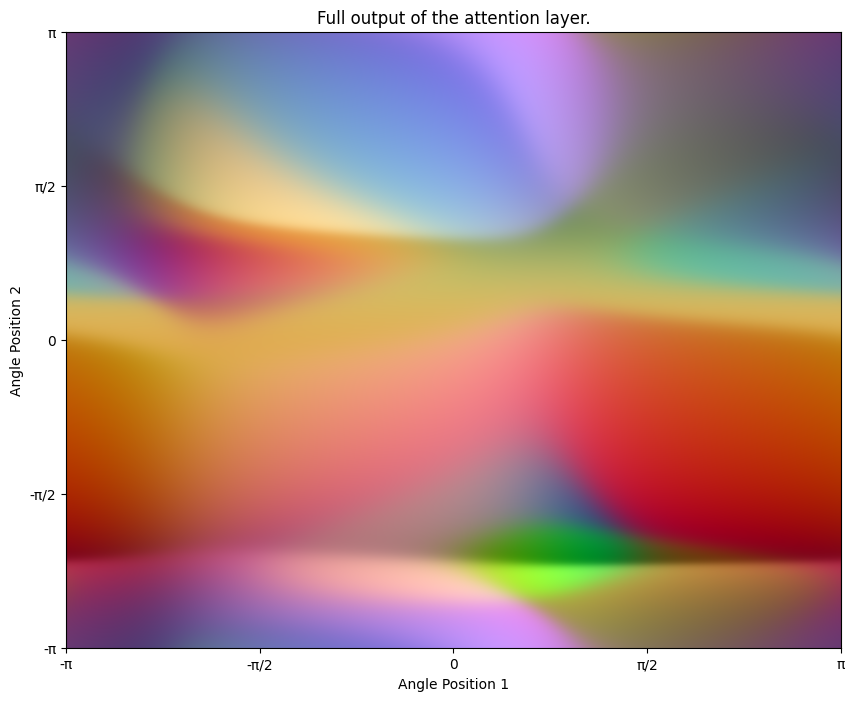

In [8]:
nb_points = 2000
layer = 0

RGB_list = []
RGB_list.append(interp.get_residual_stream(model))
full_RGB = t.zeros((nb_points, nb_points, 3))
for module in range(nb_att_mod):
    for head in range(nb_head):
        RGB_list.append(interp.token_mixing_torus(
            model, 
            module, 
            head, 
            layer, 
            mode="both", 
            hardmax=False, 
            use_OV=True, 
            nb_points=nb_points
        ))
        full_RGB += RGB_list[-1][0]
RGB_list.append(
    (
        full_RGB,
        "Full output of the attention layer."
    )
)

interp.plot_RGB_torus(RGB_list)

One way to make the coloring more salient if to graph the plot in 3d, and have the colors represent the angles of the torus. \
This way on can superpose this deformed torus on the voronoi cells to see the coloring.

In [9]:
interp.mapping_torus(model, normed_shape=True) # The shape is normalized by default for better visualization

# The attention head basis

We are trying in this section to understand how the AoT is able to memorize all of these associations. One simple hypothesis that we will test is the following: maybe the head share the work of learning associations, meaning that each head remembers some proportion of the points. Thus, the sum of the accuracy of each head should be 1 and they should remember different points. This is not the case in general: we see that some of the point are not well classified by any of the head, yet the sum of heads classify all points well.

We plot below the probability mapping made by each heads and the AoT.

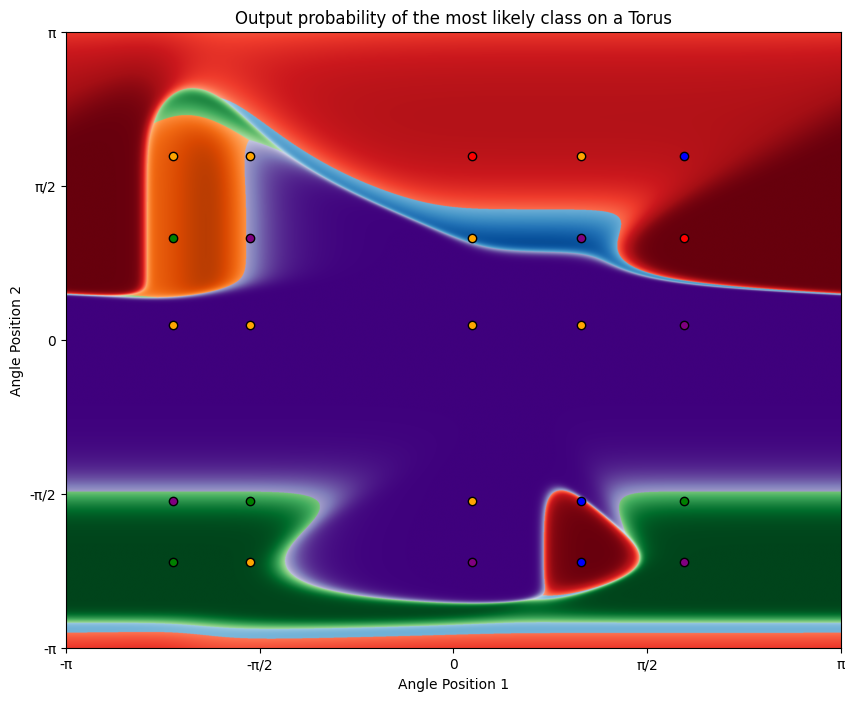

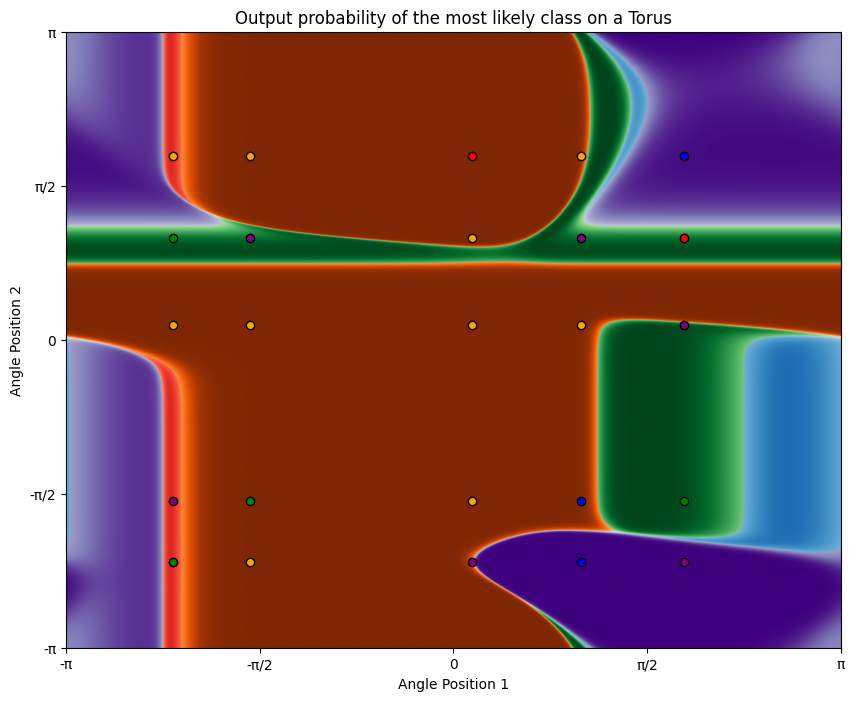

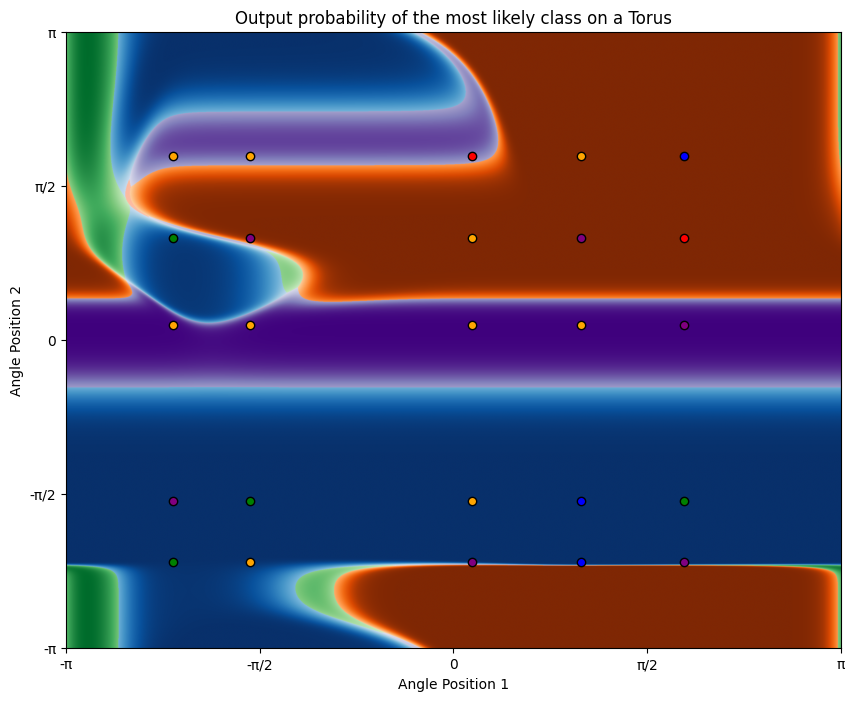

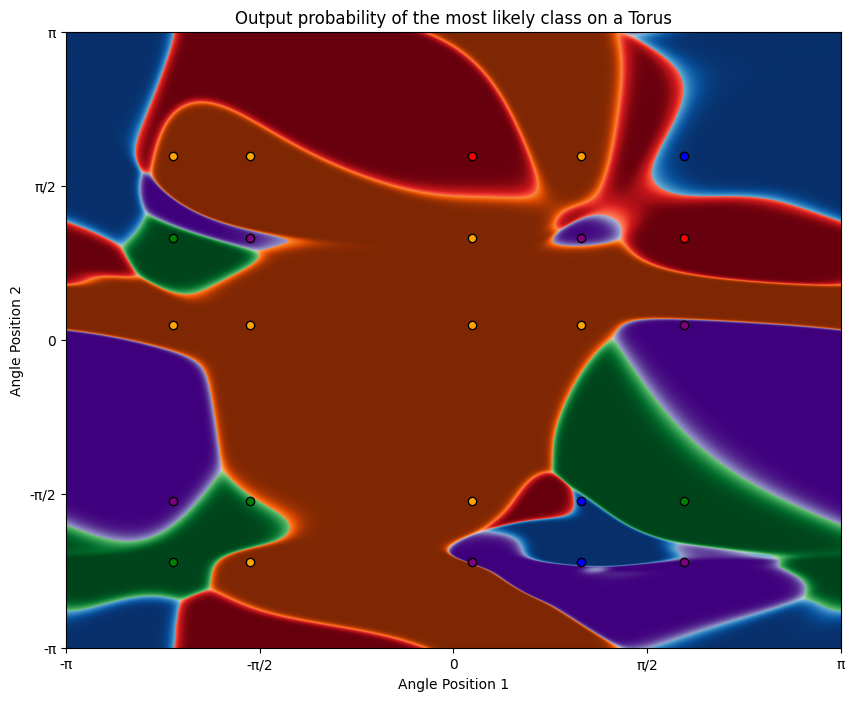

In [10]:
interp.plot_classes_torus([interp.token_mixing_torus(model, 0, 0, 0)], model)
interp.plot_classes_torus([interp.token_mixing_torus(model, 1, 0, 0)], model)
interp.plot_classes_torus([interp.token_mixing_torus(model, 2, 0, 0)], model)
interp.plot_classes_full_torus(model)

By removing all but one head of the AoT, we might be putting the model out-of-distribution: since no head was trained to predict alone, one cannot expect them to produce good output. To mitigate that effect, we propose two experiments:
* First, instead of removing completely all but one head, we cannot plot the accuracy, which is the metric of interest here, when the contribution of each head varies. To this end, we plot the accuracy of each attention head on a simplex: $Acc(c_0head_0+c_1head_1+c_2head_2)$, where $c_i\geq 0$ and $c_0+c_1+c_2=1$.
* Second, we train the head in a boosting fashion: we train alone head one, then freeze it and train head 2, etc. So if there exist a learning strategy of the sort "each head focuses on a subset of example", we could find it this way. There are again problems with this method, but the general idea is to see whether or not with this training method the AoT can obtain the same accuracy.

Let us start with the Simplexial plots: we produce triangle shaped plot of the accuracy where the proportion of each head varies, for the whole dataset, one input, or for all input that have the same output.

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



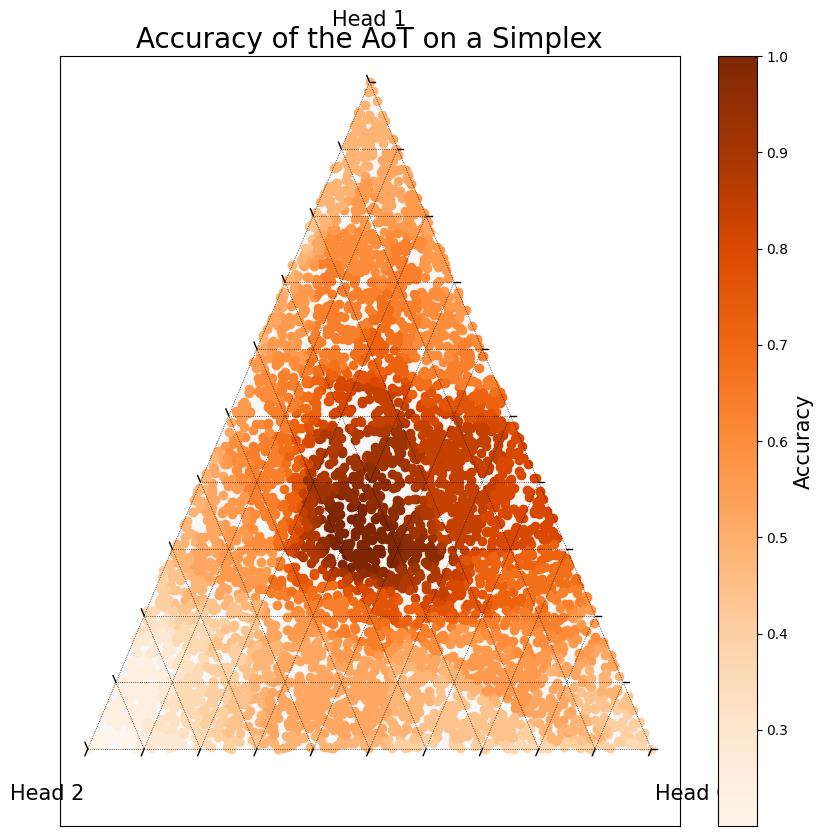

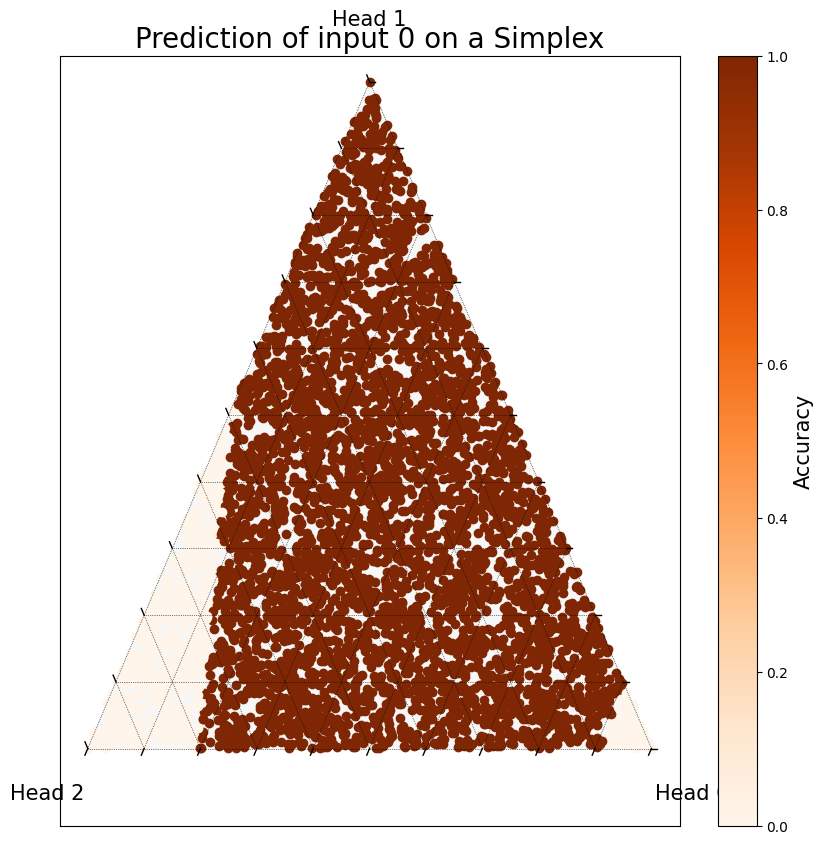

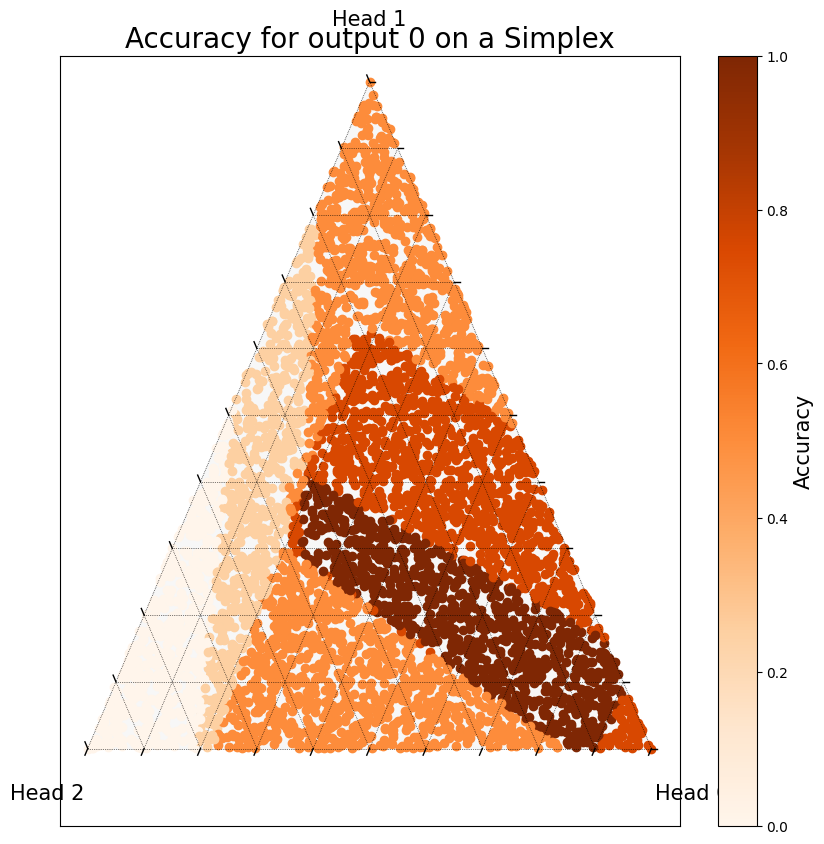

In [11]:
interp.plot_accuracy_simplex(model)
interp.plot_accuracy_simplex(model, comp_method="input", input=0)
interp.plot_accuracy_simplex(model, comp_method="output", output=0)

Analysis of the Simplexial plots:
* As expected, the accuracy over all the dataset is maximal when at the center, which correspond to the training procedure.
* Looking at the Accuracy on all input with a fixed output, it is difficult to know whether one head is responsible for learning all these examples. By playing with the seeds, one can see very different behaviors:
    * The accuracy is greater in one corner than in the others, meaning that this head is mostly responsible for learning these examples,
    * The accuracy is large in two corners, meaning that one head is useless, 
    * The accuracy is large in between two heads, meaning that both head are remembering together these examples,
    * One cannot identify any pattern.

In absence of a clearer metric for "understanding the mechanism" it is hard to conclude from that experiments that the heads are indeed performing some distributed learning.

Now on the second experiment, we train an AoT with the same number of heads as before, but heads are trained one after the other. In particular, we train the first head for longer: we do so because experimentally, we observe that the hypothesis stated above is not true, ie that the boosting AoT is not as expressive as the normal AoT. So to obtain a good loss (and reasonable training time), we decrease the training time of the second and further heads.

100%|██████████| 3000/3000 [00:15<00:00, 187.57it/s]


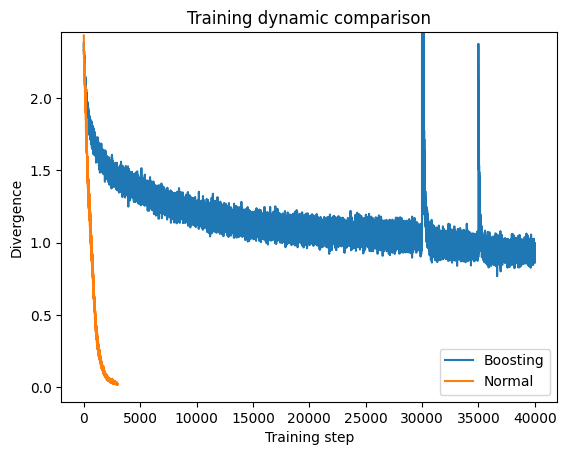

In [17]:
dict_size = 10
emb_dim = 5
t.manual_seed(2222)
pi = power_unif_law([1, 1, 1], [dict_size, dict_size, 1], dict_size)

Datas = [
    generate_data(batch_size=batch_size, num_batch=30000, pi=pi, context_window=context_window),
    generate_data(batch_size=batch_size, num_batch=5000, pi=pi, context_window=context_window),
    generate_data(batch_size=batch_size, num_batch=5000, pi=pi, context_window=context_window)
]

boost_model = AoT(emb_dim, dict_size, nb_layers, nb_att_mod, nb_head, context_window, pi)
boost_Dict = train.train_boosting(boost_model, Datas, lr=lr, next_token=True)

Data = generate_data(batch_size=batch_size, num_batch=3000, pi=pi, context_window=context_window)

unboost_model = AoT(emb_dim, dict_size, nb_layers, nb_att_mod, nb_head, context_window, pi)
unboost_Dict = train.train(unboost_model, Data, lr=lr, next_token=True)

plt.plot(boost_Dict['Loss'], label=f'Boosting')
plt.plot(unboost_Dict['Loss'], label=f'Normal')
plt.legend()
plt.ylim([-0.1, 0.1+boost_Dict['Loss'][0]])
plt.xlabel("Training step")
plt.ylabel("Divergence")
plt.title("Training dynamic comparison")
plt.show()

The above plot shows that asking the model to do boosting is less efficient than training the AoT without constraint. This means that making the heads share the memorization work is not optimal, and so that it won't be learned during training.